In [2]:
import pandas as pd
import numpy as np
import os
import random
from tqdm import tqdm
from pathlib import Path
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, losses, metrics, callbacks, saving
from tensorflow.keras import Sequential, Model, Input
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")
random.seed(45)
tf.random.set_seed(45)
np.random.seed(45)

print(tf.__version__)
import glob
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

2.19.0


In [20]:
# Load metadata to get age information
HOME_PATH = os.getcwd() + "/"
meta_train = pd.read_csv(HOME_PATH + 'meta_train.csv')

# Create mapping from image_id to age
image_to_age = dict(zip(meta_train['image_id'], meta_train['age']))
print(image_to_age)

# Load images with age labels
def load_images_with_age(paths, image_to_age):
    data = []
    ages = []
    for path in tqdm(paths):
        for img_path in os.listdir(path):
            image_id = os.path.splitext(img_path)[0] + '.jpg'
            
            # Get the age from metadata dictionary
            if image_id in image_to_age:
                image = np.array(Image.open(os.path.join(path, img_path)).convert('RGB').resize((256, 256)))
                data.append(image)
                ages.append(image_to_age[image_id])
    
    return np.array(data), np.array(ages)

# Load all training images
print("Loading training images...")
images, ages = load_images_with_age(glob.glob(HOME_PATH + 'train_images/*'), image_to_age)

print(f"Loaded {len(images)} images")
# print(f"Age range: {ages.min()} to {ages.max()} days")
print(f"Average age: {ages.mean():.2f} days")

{'100330.jpg': 45, '100365.jpg': 45, '100382.jpg': 45, '100632.jpg': 45, '101918.jpg': 45, '102353.jpg': 45, '102848.jpg': 45, '103051.jpg': 45, '103702.jpg': 45, '103920.jpg': 45, '104800.jpg': 45, '106539.jpg': 45, '108320.jpg': 45, '108541.jpg': 45, '100049.jpg': 50, '100541.jpg': 50, '100622.jpg': 50, '100795.jpg': 50, '100967.jpg': 50, '101173.jpg': 50, '101229.jpg': 50, '101425.jpg': 50, '101780.jpg': 50, '101930.jpg': 50, '101973.jpg': 50, '102190.jpg': 50, '102667.jpg': 50, '102726.jpg': 50, '102981.jpg': 50, '103435.jpg': 50, '103734.jpg': 50, '104108.jpg': 50, '104255.jpg': 50, '104702.jpg': 50, '104975.jpg': 50, '105122.jpg': 50, '105273.jpg': 50, '105291.jpg': 50, '105443.jpg': 50, '105662.jpg': 50, '105794.jpg': 50, '106089.jpg': 50, '106339.jpg': 50, '107246.jpg': 50, '108353.jpg': 50, '108520.jpg': 50, '108673.jpg': 50, '108748.jpg': 50, '108817.jpg': 50, '108868.jpg': 50, '108883.jpg': 50, '109306.jpg': 50, '109332.jpg': 50, '109422.jpg': 50, '109441.jpg': 50, '109514.j

100%|██████████| 10/10 [00:48<00:00,  4.83s/it]


Loaded 10407 images
Average age: 64.04 days


In [22]:
# Configuration
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 100
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]
k_folds = 3  # Number of folds

In [23]:
# MLP helper function
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

class Patches(layers.Layer):
    def __init__(self, patch_size, **kwargs):  # Add **kwargs to handle extra arguments
        super(Patches, self).__init__(**kwargs)  # Pass kwargs to parent constructor
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches
        
    def get_config(self):
        config = super(Patches, self).get_config()
        config.update({"patch_size": self.patch_size})
        return config
    
    @classmethod
    def from_config(cls, config):
        patch_size = config.pop("patch_size")  # Extract your custom parameter
        # Create instance with your param and pass remaining config as kwargs
        return cls(patch_size=patch_size, **config)

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):  # Add **kwargs
        super(PatchEncoder, self).__init__(**kwargs)  # Pass kwargs to parent
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded
        
    def get_config(self):
        config = super(PatchEncoder, self).get_config()
        config.update({
            "num_patches": self.num_patches,
            "projection_dim": self.projection_dim
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        num_patches = config.pop("num_patches")  # Extract your custom parameters
        projection_dim = config.pop("projection_dim")
        # Create instance with your params and pass remaining config as kwargs
        return cls(num_patches=num_patches, projection_dim=projection_dim, **config)


In [24]:
# ViT Model for Age Regression with adjustable input shape for preprocessing
def create_vit_regressor(input_images):
    # Create data augmentation inside model
    data_augmentation = keras.Sequential(
        [
            layers.Normalization(),
            layers.Resizing(image_size, image_size),
            layers.RandomFlip("horizontal"),
            layers.RandomRotation(factor=0.02),
            layers.RandomZoom(height_factor=0.2, width_factor=0.2),
        ],
        name="data_augmentation",
    )
    
    # Adapt normalization layer to current fold's data
    data_augmentation.layers[0].adapt(input_images)
    
    inputs = layers.Input(shape=(256, 256, 3))
    
    # Augment data
    augmented = data_augmentation(inputs)
    
    # Create patches
    patches = Patches(patch_size)(augmented)
    
    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        
        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        
        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        
        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        
        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        
        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    
    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    
    # Output layer for regression (single neuron for age)
    output = layers.Dense(1, activation='linear')(features)
    
    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [ ]:
# K-Fold Cross Validation
def perform_kfold_training():
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    fold_results = []
    fold_histories = []
    ensemble_predictions = []
    
    # Create directory for k-fold models
    kfold_model_dir = HOME_PATH + 'paddy_models/kfold_models/'
    os.makedirs(kfold_model_dir, exist_ok=True)
    
    print(f"\nStarting {k_folds}-Fold Cross Validation...")
    
    for fold, (train_idx, val_idx) in enumerate(kfold.split(images), 1):
        print(f"\n{'='*50}")
        print(f"Training Fold {fold}/{k_folds}")
        print(f"{'='*50}")
        
        # Split data for current fold
        X_train_fold, X_val_fold = images[train_idx], images[val_idx]
        y_train_fold, y_val_fold = ages[train_idx], ages[val_idx]
        
        # Calculate age statistics for current fold
        age_mean_fold = y_train_fold.mean()
        age_std_fold = y_train_fold.std()
        
        # Normalize ages for current fold
        y_train_norm_fold = (y_train_fold - age_mean_fold) / age_std_fold
        y_val_norm_fold = (y_val_fold - age_mean_fold) / age_std_fold
        
        print(f"Training samples: {len(X_train_fold)}")
        print(f"Validation samples: {len(X_val_fold)}")
        print(f"Age mean: {age_mean_fold:.2f}, std: {age_std_fold:.2f}")
        
        # Create model for current fold
        model = create_vit_regressor(X_train_fold)
        
        # Compile model
        optimizer = keras.optimizers.AdamW(
            learning_rate=learning_rate, weight_decay=weight_decay
        )
        
        model.compile(
            optimizer=optimizer,
            loss='mean_absolute_error',
            metrics=['mae', 'mse']
        )
        
        # Callbacks
        filepath = f"{kfold_model_dir}best_vit_age_model_fold_{fold}.weights.h5"
        
        # Modify the checkpoint callback
        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            filepath=filepath,
            monitor="val_loss",
            verbose=1,
            save_best_only=True,
            save_weights_only=True,  # Only save weights, not the whole model
            mode='min'
        )
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.2,
            patience=8,
            verbose=1,
            mode="min",
            min_delta=0.001,
            cooldown=2,
            min_lr=1e-7
        )
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=20,
            verbose=1,
            mode="min",
            restore_best_weights=True
        )
        
        # Train model for current fold
        history = model.fit(
            x=X_train_fold,
            y=y_train_norm_fold,
            batch_size=batch_size,
            epochs=num_epochs,
            validation_data=(X_val_fold, y_val_norm_fold),
            callbacks=[checkpoint, reduce_lr, early_stopping],
            verbose=1
        )
        
        # Evaluate on validation set
        val_predictions = model.predict(X_val_fold)
        val_predictions_original = val_predictions.flatten() * age_std_fold + age_mean_fold
        y_val_original = y_val_fold
        
        mae = mean_absolute_error(y_val_original, val_predictions_original)
        mse = mean_squared_error(y_val_original, val_predictions_original)
        rmse = np.sqrt(mse)
        
        # Store results
        fold_result = {
            'fold': fold,
            'mae': mae,
            'rmse': rmse,
            'mse': mse,
            'age_mean': age_mean_fold,
            'age_std': age_std_fold,
            'best_val_loss': min(history.history['val_loss']),
            'final_val_loss': history.history['val_loss'][-1]
        }
        fold_results.append(fold_result)
        fold_histories.append(history)
        
        # Create a fresh model
        best_model = create_vit_regressor(X_train_fold)
        best_model.compile(
            optimizer=optimizer,
            loss='mean_absolute_error',
            metrics=['mae', 'mse']
        )
        # Load just the weights
        best_model.load_weights(filepath)
        
        ensemble_predictions.append((best_model, age_mean_fold, age_std_fold))
        
        print(f"\nFold {fold} Results:")
        print(f"Validation MAE: {mae:.2f} days")
        print(f"Validation RMSE: {rmse:.2f} days")
        print(f"Best validation loss: {fold_result['best_val_loss']:.4f}")
        
        # Clean up model from memory
        del model
        del best_model
        tf.keras.backend.clear_session()
    
    return fold_results, fold_histories, ensemble_predictions

In [26]:
# Perform k-fold training
fold_results, fold_histories, ensemble_predictions = perform_kfold_training()

# Analyze k-fold results
print("\n" + "="*50)
print("K-Fold Cross Validation Results")
print("="*50)

mae_scores = [result['mae'] for result in fold_results]
rmse_scores = [result['rmse'] for result in fold_results]

print(f"\nMAE per fold: {mae_scores}")
print(f"RMSE per fold: {rmse_scores}")
print(f"\nAverage MAE: {np.mean(mae_scores):.2f} ± {np.std(mae_scores):.2f}")
print(f"Average RMSE: {np.mean(rmse_scores):.2f} ± {np.std(rmse_scores):.2f}")


Starting 3-Fold Cross Validation...

Training Fold 1/3
Training samples: 6938
Validation samples: 3469
Age mean: 64.06, std: 8.91

Epoch 1/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - loss: 2.6742 - mae: 2.6742 - mse: 28.3614
Epoch 1: val_loss improved from inf to 0.80103, saving model to c:\Users\Admin\Desktop\COSC2753_A2_MachineLearning/paddy_models/kfold_models/best_vit_age_model_fold_1.weights.h5
217/217 ━━━━━━━━━━━━━━━━━━━━ 161s 633ms/step - loss: 2.6683 - mae: 2.6683 - mse: 28.2679 - val_loss: 0.8010 - val_mae: 0.8010 - val_mse: 0.9653 - learning_rate: 0.0010
Epoch 2/100
217/217 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - loss: 0.8105 - mae: 0.8105 - mse: 1.0623
Epoch 2: val_loss improved from 0.80103 to 0.76904, saving model to c:\Users\Admin\Desktop\COSC2753_A2_MachineLearning/paddy_models/kfold_models/best_vit_age_model_fold_1.weights.h5
217/217 ━━━━━━━━━━━━━━━━━━━━ 136s 629ms/step - loss: 0.8104 - mae: 0.8104 - mse: 1.0623 - val_loss: 0.7690 - val_mae: 0.7690 - val_mse: 1.0078 

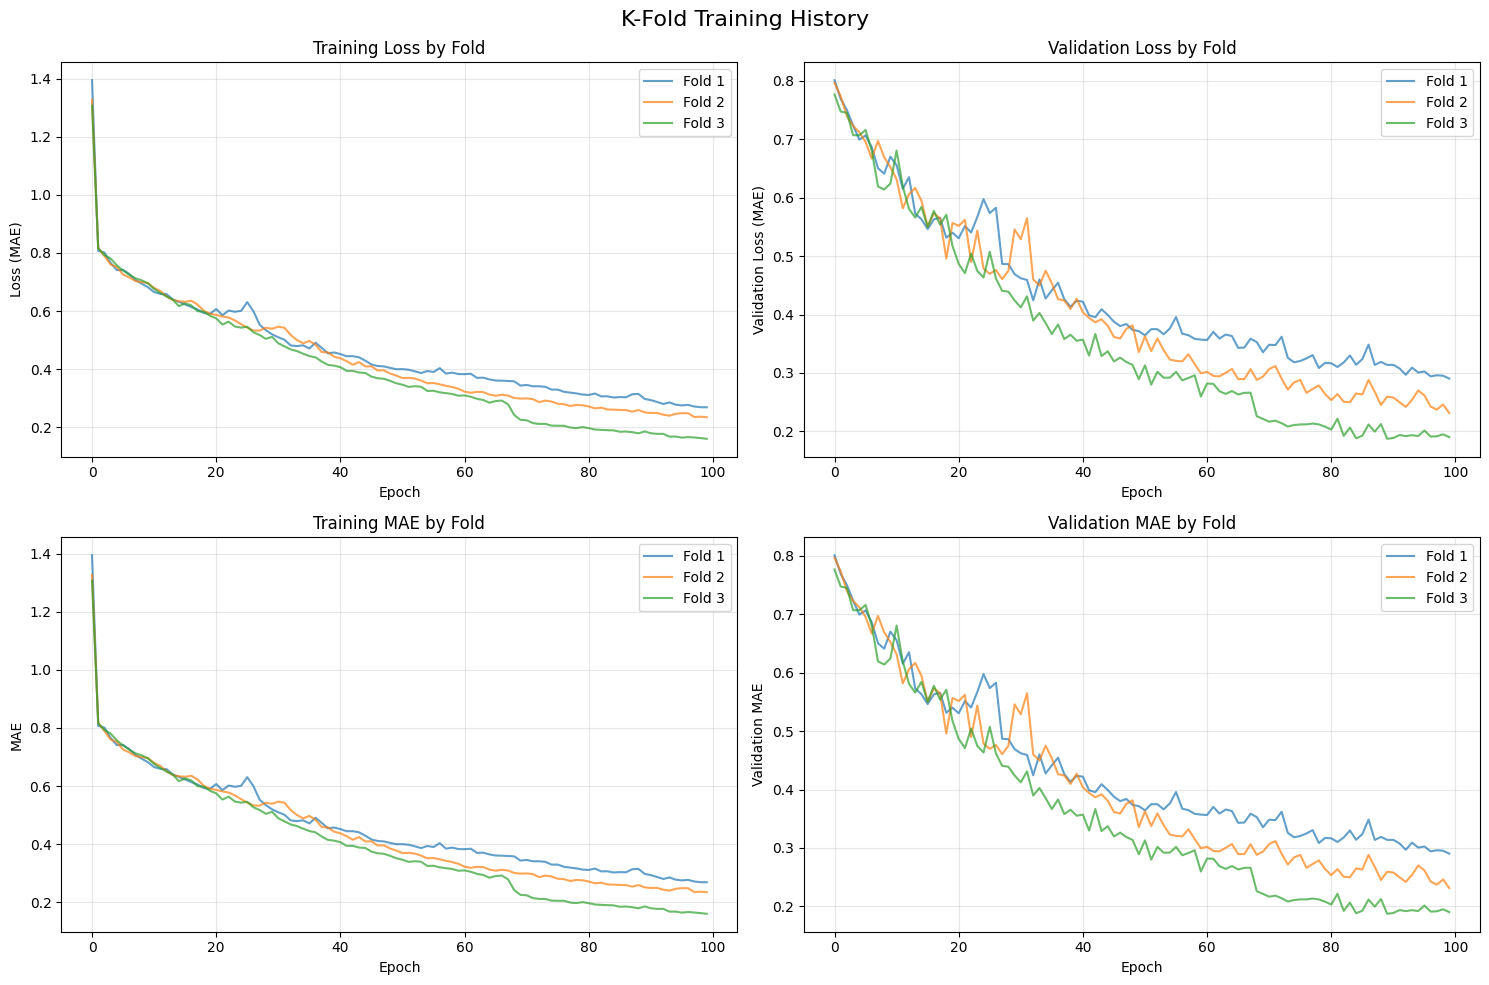

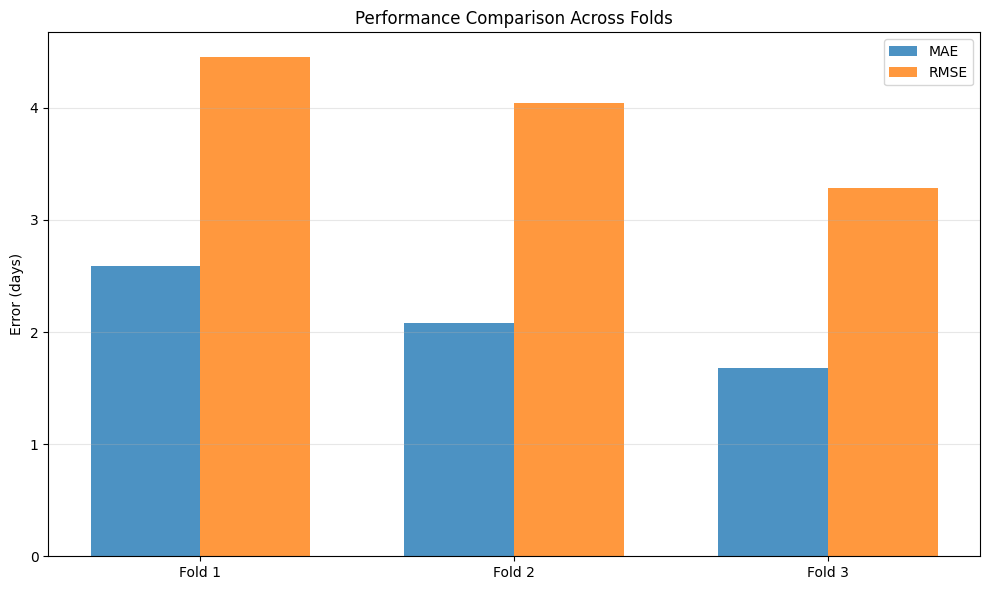


Loading test images...


100%|██████████| 3469/3469 [00:17<00:00, 200.56it/s]



Making ensemble predictions...

Ensemble prediction statistics:
Min predicted age: 40.19 days
Max predicted age: 82.70 days
Mean predicted age: 64.47 days


In [27]:
# Save k-fold results
results_df = pd.DataFrame(fold_results)
results_df.to_csv(HOME_PATH + 'kfold_results.csv', index=False)

# Plot k-fold training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('K-Fold Training History', fontsize=16)

# Plot loss
axes[0, 0].set_title('Training Loss by Fold')
for i, history in enumerate(fold_histories):
    axes[0, 0].plot(history.history['loss'], label=f'Fold {i+1}', alpha=0.7)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss (MAE)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot validation loss
axes[0, 1].set_title('Validation Loss by Fold')
for i, history in enumerate(fold_histories):
    axes[0, 1].plot(history.history['val_loss'], label=f'Fold {i+1}', alpha=0.7)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Validation Loss (MAE)')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot MAE
axes[1, 0].set_title('Training MAE by Fold')
for i, history in enumerate(fold_histories):
    axes[1, 0].plot(history.history['mae'], label=f'Fold {i+1}', alpha=0.7)
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('MAE')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot validation MAE
axes[1, 1].set_title('Validation MAE by Fold')
for i, history in enumerate(fold_histories):
    axes[1, 1].plot(history.history['val_mae'], label=f'Fold {i+1}', alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Validation MAE')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(HOME_PATH + 'kfold_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot fold comparison
plt.figure(figsize=(10, 6))
folds = [f'Fold {i+1}' for i in range(k_folds)]
x = np.arange(len(folds))
width = 0.35

plt.bar(x - width/2, mae_scores, width, label='MAE', alpha=0.8)
plt.bar(x + width/2, rmse_scores, width, label='RMSE', alpha=0.8)

plt.ylabel('Error (days)')
plt.title('Performance Comparison Across Folds')
plt.xticks(x, folds)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig(HOME_PATH + 'kfold_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Generate ensemble predictions for test set
def load_test_images():
    test_data = []
    test_ids = []
    
    test_path = HOME_PATH + 'test_images/'
    for img_file in tqdm(os.listdir(test_path)):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(test_path, img_file)
            image = np.array(Image.open(img_path).convert('RGB').resize((256, 256)))
            test_data.append(image)
            test_ids.append(img_file.split('.')[0])
    
    return np.array(test_data), test_ids

# Load test images
print("\nLoading test images...")
test_images, test_ids = load_test_images()

# Ensemble prediction
print("\nMaking ensemble predictions...")
all_predictions = []

for model, age_mean, age_std in ensemble_predictions:
    predictions_norm = model.predict(test_images, verbose=0)
    predictions_original = predictions_norm.flatten() * age_std + age_mean
    all_predictions.append(predictions_original)

# Average predictions across folds
ensemble_predictions_avg = np.mean(all_predictions, axis=0)

# Create submission dataframe
submission_df = pd.DataFrame({
    'image_id': test_ids,
    'age': ensemble_predictions_avg.astype(int).astype(str)
})

# Save ensemble predictions
submission_df.to_csv(HOME_PATH + 'age_predictions_kfold_ensemble.csv', index=False)

print(f"\nEnsemble prediction statistics:")
print(f"Min predicted age: {ensemble_predictions_avg.min():.2f} days")
print(f"Max predicted age: {ensemble_predictions_avg.max():.2f} days")
print(f"Mean predicted age: {ensemble_predictions_avg.mean():.2f} days")

In [28]:
# Also save individual fold predictions for analysis
individual_predictions_df = pd.DataFrame({
    'image_id': test_ids,
    **{f'fold_{i+1}_prediction': pred for i, pred in enumerate(all_predictions)}
})
individual_predictions_df.to_csv(HOME_PATH + 'age_predictions_individual_folds.csv', index=False)

# Analyze prediction variance across folds
prediction_std = np.std(all_predictions, axis=0)
prediction_variance_df = pd.DataFrame({
    'image_id': test_ids,
    'ensemble_prediction': ensemble_predictions_avg,
    'prediction_std': prediction_std,
    'coefficient_of_variation': prediction_std / ensemble_predictions_avg
})
prediction_variance_df.to_csv(HOME_PATH + 'prediction_variance_analysis.csv', index=False)

print(f"\nPrediction variance statistics:")
print(f"Average standard deviation across predictions: {prediction_std.mean():.2f}")
print(f"Maximum standard deviation: {prediction_std.max():.2f}")
print(f"Images with high prediction variance (std > 10): {sum(prediction_std > 10)}")

# Save age statistics (using average from all folds)
age_stats = {
    'mean': np.mean([result['age_mean'] for result in fold_results]),
    'std': np.mean([result['age_std'] for result in fold_results])
}

import json
with open(HOME_PATH + 'age_stats_kfold.json', 'w') as f:
    json.dump(age_stats, f)

print("\nK-fold cross-validation completed successfully!")


Prediction variance statistics:
Average standard deviation across predictions: 1.43
Maximum standard deviation: 13.38
Images with high prediction variance (std > 10): 19

K-fold cross-validation completed successfully!
